## Week 2: Spectrograms

This week we will be learning how to make a spectrogram from a numpy array representing a sound waveform.

How we are able to do this is by using a fourier transforms which we talked about in our session. Let's now start walking through the steps of how to implment a short-time fourier transform which is what we will use for our music recognition algorithm.

In [4]:
from scipy import signal as scipy_signal
import numpy as np
import matplotlib.pyplot as plt

# Discrete fourier transform

This is the simplest form of the fouerir transform. 
Given the DFT formula, implement this function below.

<img src="discrete+Fourier+transform+formula.webp">

In [5]:
def manual_dft(audio, sr):
    """ 
    Calculate the dft for the given audio file. 
    
    Transforms audio from the time domain to the frequency domain by calculating
    the fourier coefficients for each frequency bins. The value in each bin is the
    magnitude of that frequency.
    """
    
    N = len(audio)
    X = np.zeros(N, dtype = complex)
    sinusoidal_signal = np.zeros(N, dtype = complex)
 
    # TODO: Implement the discrete fourier transform (DFT)
    for k in range(N):
        for n in range(N):
            X[k] += audio[n] * np.exp(-2j * np.pi * (k/N) * n) 
    # Note to self: this is the correct formula but it is extremly slow becuase it uses double for loops. 
    # Return the final transformed data
    return(X)

In [6]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import scipy
from pydub import AudioSegment

audio_path = "/Users/benjaminpease/output.wav"
ipd.Audio(audio_path)

audio, sr = librosa.load(audio_path, sr=44100, duration = 10)
print(len(audio))
print(audio)
manual_dft(audio[100000:101000], sr)

# Notice how long this takes to work 

441000
[0.         0.         0.         ... 0.15463257 0.14880371 0.1427002 ]


array([ 2.77557373e-01+0.00000000e+00j, -3.12314277e-01+3.76981157e-02j,
       -7.03745098e-02-2.57485534e-02j, -1.23726050e-02+5.06607680e-02j,
       -1.55952087e-02-2.69204303e-02j, -2.99882267e-02+7.38372110e-03j,
       -9.88932528e-03-1.97658216e-02j, -1.58818120e-02-1.00280379e-02j,
        1.96343726e-03+4.61078226e-03j, -1.32306286e-02+1.60361108e-03j,
       -2.07625447e-03-2.12175107e-03j, -6.66956496e-03+1.31199147e-03j,
       -3.18974633e-03-1.49017970e-02j, -4.62083638e-03+7.53010641e-04j,
       -1.20094295e-02-6.24485242e-04j,  2.44155175e-03-1.58592720e-04j,
       -1.13242819e-02-5.09986136e-03j, -7.22363668e-03+9.52900074e-04j,
       -1.00701319e-02-1.35088687e-02j,  1.02203608e-02+4.51494661e-03j,
       -1.31188353e-02-2.39520957e-03j, -6.03135988e-03-2.65604247e-03j,
        6.05805400e-03+5.11744973e-03j,  2.43291585e-03-7.26074520e-05j,
        4.04789239e-03-6.10498579e-03j,  3.27086997e-03-2.87209330e-03j,
       -2.41953491e-03+8.30218099e-03j, -1.93012322

# Fast Fourier Transform (FFT)

Whiletaking the discrete fourier transform is the most straightforward way of doing a fourier transform, since it iterates through all frequency bands for the entire length of the file, the computation can be very slow as we increase the length of our audio file. Luckily we can speed up this process using a fast foureir transform.

As mentioned in our presentation, the fast fourier transform takes advantage of fourier transform symmetry in order to apply a divide-and-conquer approach to calculating the fourier transform in much less time. It splits the original signal into even and odd subarrys and takes the fourier transform of that segment, then combinines it together to get the fourier transform of the original signal in far less time. Note: we can speed this up even more by taking the FFT of each split instead of the DFT, allowing for a recursive approach.

<img src="full_fft.png">

Notice how this only gives us one half of the fourier transform. Luckily we can easily retrieve the other hald by subtracting the even by the odd portion. Concatenating these two together gives the final fourier transform for our original signal.

<img src="two_sides_fft.png">

Try implmementing this yourself below. Note: you may want to look up some indexing and concatenation tricks for python arrays.

In [7]:
def manual_fft(audio, sr):
    """ 
    Fast Fourier Transform of the audio file.
    Uses the Cooley-Turkey formula.
    
    
    """
    N = len(audio)
    audio = np.asarray(audio, dtype=complex)
    
    if not np.log2(N).is_integer():
        next_pow2 = 1 << (N-1).bit_length()
        audio = np.pad(audio, (0, next_pow2 - N), mode='constant')
        N = next_pow2
        
    # TODO: Base case: After a sufficient number of splits, use dft 
    if N <= 32:
        n = np.arange(N)
        k = n.reshape((N,1))
        W = np.exp(-2j * np.pi * k * n /N)
        return (W @ audio) # the @ symbol means matrix opperations so I think this returns the matrix product of aduio and W
    # TODO: Divide: Take advatange of ft symmetry so divide the dft computation into
    # even and odd parts
    even = manual_fft(audio[::2],sr)
    odd = manual_fft(audio[1::2],sr)
        
    # factor for the odd terms
    factor = np.exp(-2j * np.pi * np.arange(N) / N)

    # using factor, do a weighted combination of the even and odd parts
    X = np.concatenate([even + (factor[:N//2] * odd),even - (factor[:N//2] * odd)])
    return X

In [8]:
my_fft = manual_fft(audio,None)
fft_result = np.fft.fft(audio)

print(my_fft)
print(fft_result)

[-5.7355957 +0.j          4.21817364+4.00277986j  1.32649771+4.39482617j
 ... -1.74580668-0.46396734j  1.32649771-4.39482617j
  4.21817364-4.00277986j]
[-5.7355957+0.j          4.307377 +0.28224367j  5.20764  -0.92471856j ...
  3.6153011+2.9646547j   5.20764  +0.92471856j  4.307377 -0.28224367j]


# TEST FFT

Lets test our fourier transform function by generating a test wave made of 3-5 frequencies. See if your spectrogram highights the frequencies at the correct magnitude that you specified.

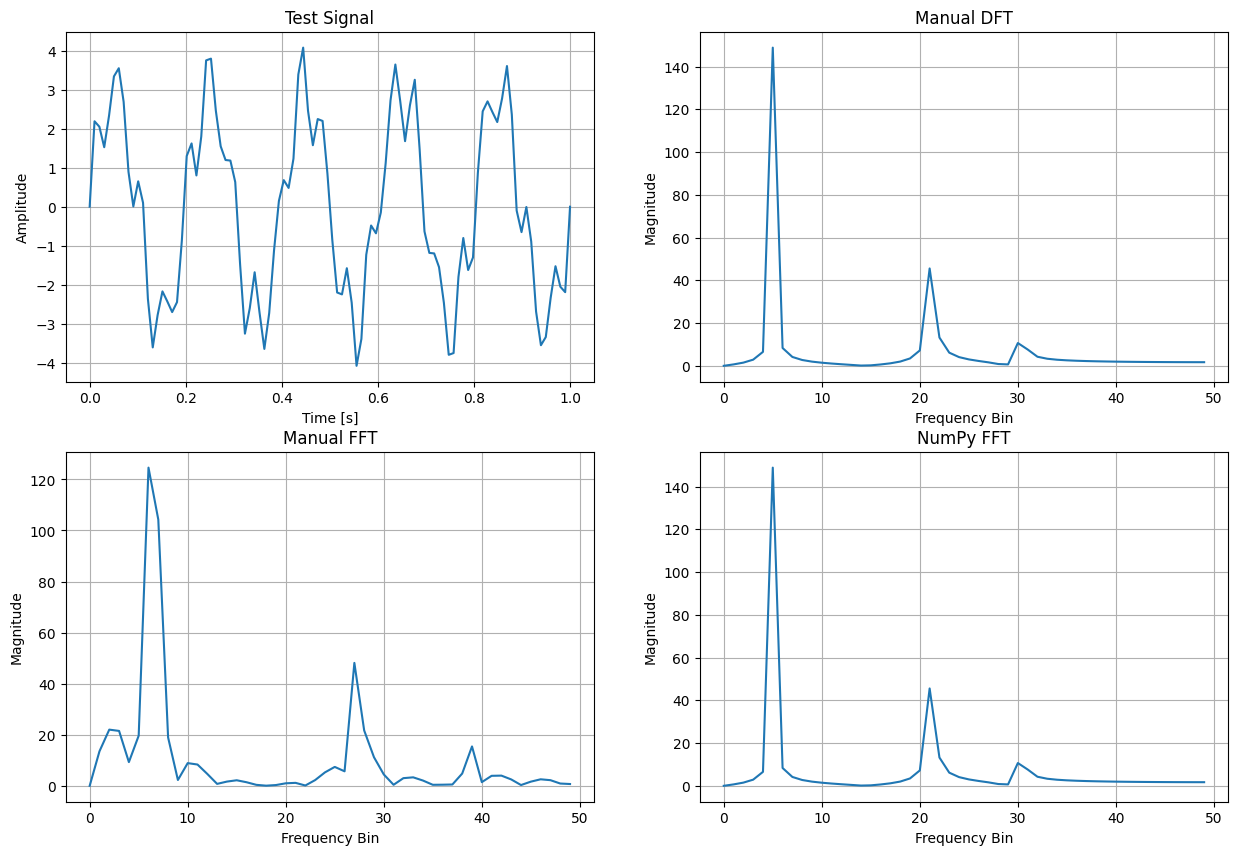

In [9]:
t = np.linspace(0, 1.0, 100)

# change/add frequencies here
freq1 = 21
freq2 = 5
freq3 = 30

# change/add magnitudes here
mag1 = 1.0
mag2 = 3
mag3 = 0.3

# combine the sin waves
signal_test = (mag1 * np.sin(2 * np.pi * freq1 * t) +
                mag2 * np.sin(2 * np.pi * freq2 * t) + 
                mag3 * np.sin(2 * np.pi * freq3 * t)) 

X = manual_dft(signal_test, 100)
X_fft = manual_fft(signal_test, 100)
X_np = np.fft.fft(signal_test)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].plot(t, signal_test)
axes[0, 0].set_title("Test Signal")
axes[0, 0].set_xlabel("Time [s]")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid()

# apply the Nyquist theorem to only show the positive frequencies
N = len(signal_test)
axes[0, 1].plot(np.abs(X[:N // 2]), label="Manual DFT")
axes[0, 1].set_title("Manual DFT")
axes[0, 1].set_xlabel("Frequency Bin")
axes[0, 1].set_ylabel("Magnitude")
axes[0, 1].grid()

axes[1, 0].plot(np.abs(X_fft[:N // 2]), label="Manual FFT")
axes[1, 0].set_title("Manual FFT")
axes[1, 0].set_xlabel("Frequency Bin")
axes[1, 0].set_ylabel("Magnitude")
axes[1, 0].grid()

axes[1, 1].plot(np.abs(X_np[:N // 2]), label="NumPy FFT")
axes[1, 1].set_title("NumPy FFT")
axes[1, 1].set_xlabel("Frequency Bin")
axes[1, 1].set_ylabel("Magnitude")
axes[1, 1].grid()

# Short-Time Fourier Transform

While the plots generated above are able to show the distribution of frequencies in the waveform, we have no measure of how the frequencies in the wave change over time. For this, we use the Short-Time Fourier Transform!

The Short-Time Fourier Transform takes a snapshot of the FT calculated at constant size "time windows" throughout the file. The magnitude of each frequency is projected onto the spectrogram at each time, where the frequency is the y-axis and the color of the band is equal to the magnitude of that given frequency.

In [10]:
def hamming_window(N):
    """ Generate the Hamming window for the size of our audio file. """
    nums = np.arange(N)
    return .54 - .46 * np.cos((2 * np.pi * nums) / (N - 1))

def pad_signal(signal, nperseg):
    """ Pad the audio to the correct length. """
    
    # sl = len(signal)
    
    pl = nperseg // 2
    
    return np.concatenate([np.zeros(pl), signal, np.zeros(pl)])

Below will be your implementation of the stft function. Fill out the TODOs ans reach out if you have any questions.

In [111]:
# we will use the discrete forier transform formula since in
# digital audio files, audio is stored in discrete packets for 
# each timestep.
def manual_stft(audio, sr, nperseg=1024):
    """
    Input:
    audio: NP-Array cntain the amplitude over time for this file
    sr (Sampling rate): int for the rate 
    
    Ooutput:
    frequencies:
    """
    # nperseg = 1024
    
    # This is hop length, it represents how much we move the window each time
    # Notice that it is equal to nperseg * 1.5 meaning we have 50% overlap with the previous window
    hop_length = nperseg // 2
    
    # length of the original audio file
    N = len(audio)
    
    # output array
    X = np.zeros(N, dtype=complex)
    
    # TODO: pad the audio file with the function above
    padded_audio = pad_signal(audio, nperseg)

    # TODO: create the hamming window for this audio file
    windower = hamming_window(nperseg)
    # get the total size of our padded audio
    padded_len = len(padded_audio)
    
    # TODO: computer the number of complete windows we can fit
    num_segs = int((padded_len-nperseg)/(hop_length))

    # TODO: Calculate the number of frequency bins needed
    # Hint: Nyquist theorem means that we onl need half the total possible bins
    freq_bins = int((nperseg / 2) + 1)
    
    stft_matrix = np.zeros((freq_bins, num_segs), dtype = complex)

    # Iterate through each segment in the audio file
    for i in range(num_segs):
        
        # TODO: Calculate the start and end of this segment
        start = hop_length * i
        end = (hop_length * i) + nperseg
        
        
        if end > padded_len:
            # edge case where our index is longer than our audio file - logic error
            break
        
        # TODO: get the segment of the signal inside the window and apply the window function
        segment = padded_audio[start:end]
        windowed_segment = windower * segment

        # TODO: calculate the fft of this segment
        fft_result = np.fft.fft(windowed_segment)

        # normalize the result by the sampling rate
        fft_result /= (sr)

        
        # TODO: apply Nyquist function and store the result in the stft matrix
        # Hint 1: Think about how nperseg relates to the number of frequency bins
        # Hint 2: Since the fourier transform is symmetric, we only need to store half the values. 
        #         We will need to scale some values by 2 to account for this.
        stft_matrix[0, i] = np.abs(fft_result[0])
        stft_matrix[1:-1, i] = np.abs(2 * fft_result[1:freq_bins-1])
        stft_matrix[-1, i] = np.abs(fft_result[nperseg // 2])
        
    # get each frequency bin
    frequencies = np.linspace(0, sr / 2, freq_bins)
        
    # account for the pad in our time calculation
    offset = -nperseg / 2 / sr
        
    # get the timesteps for each measurement
    times = np.arange(num_segs) * hop_length / sr + nperseg / 2 / sr + offset
    
    # return the frequency bins, time stamps, and frequency/maginitude measurements
    return frequencies, times, stft_matrix

In [112]:
manual_stft(audio,44100)

(array([    0.        ,    43.06640625,    86.1328125 ,   129.19921875,
          172.265625  ,   215.33203125,   258.3984375 ,   301.46484375,
          344.53125   ,   387.59765625,   430.6640625 ,   473.73046875,
          516.796875  ,   559.86328125,   602.9296875 ,   645.99609375,
          689.0625    ,   732.12890625,   775.1953125 ,   818.26171875,
          861.328125  ,   904.39453125,   947.4609375 ,   990.52734375,
         1033.59375   ,  1076.66015625,  1119.7265625 ,  1162.79296875,
         1205.859375  ,  1248.92578125,  1291.9921875 ,  1335.05859375,
         1378.125     ,  1421.19140625,  1464.2578125 ,  1507.32421875,
         1550.390625  ,  1593.45703125,  1636.5234375 ,  1679.58984375,
         1722.65625   ,  1765.72265625,  1808.7890625 ,  1851.85546875,
         1894.921875  ,  1937.98828125,  1981.0546875 ,  2024.12109375,
         2067.1875    ,  2110.25390625,  2153.3203125 ,  2196.38671875,
         2239.453125  ,  2282.51953125,  2325.5859375 ,  2368.65

# Testing Manual FT

You have no implemented the short-time fourier transform function! Now lets put it to the test. The following functions will visualize spectrograms created by your STFT function compared to spectrograms created by the scipy version.

There is no need to change any of the function below.

In [113]:
def compare_with_scipy(audio, fs, nperseg=1024, noverlap=None):
    """
    Compare manual implementation with SciPy's STFT
    """
    if noverlap is None:
        noverlap = nperseg - (nperseg // 4)  # 75% overlap
        
    nperseg = 1024
    hop_length = nperseg + (nperseg // 2)
    
    
    print(f"STFT Parameters:")
    print(f"  nperseg: {nperseg}")
    print(f"  noverlap: {noverlap}")
    print(f"  hop_length: {hop_length}")
    print(f"  fs: {fs}")
    
    # Manual implementation
    freq_manual, time_manual, stft_manual = manual_stft(audio, fs, nperseg)
    
    # SciPy implementation for comparison
    freq_scipy, time_scipy, stft_scipy = scipy_signal.stft(
        audio, fs=fs, window="hamming", nperseg=nperseg, noverlap=nperseg - hop_length,
        padded=True, return_onesided=True
    )
    
    print(f"\nResults comparison:")
    print(f"Manual - Frequencies shape: {freq_manual.shape}, Times shape: {time_manual.shape}")
    print(f"Manual - STFT shape: {stft_manual.shape}")
    print(f"SciPy  - Frequencies shape: {freq_scipy.shape}, Times shape: {time_scipy.shape}")
    print(f"SciPy  - STFT shape: {stft_scipy.shape}")
    
    # Calculate difference
    if stft_manual.shape == stft_scipy.shape:
        diff = np.abs(stft_manual - stft_scipy)
        max_diff = np.max(diff)
        mean_diff = np.mean(diff)
        print(f"Max difference in STFT: {max_diff:.2e}")
        print(f"Mean difference in STFT: {mean_diff:.2e}")
    
    return (freq_manual, time_manual, stft_manual), (freq_scipy, time_scipy, stft_scipy)

def plot_stft_comparison(audio, fs, nperseg=1024):
    """
    Plot STFT spectrograms for comparison
    """
    (freq_manual, time_manual, stft_manual), (freq_scipy, time_scipy, stft_scipy) = \
        compare_with_scipy(audio, fs, nperseg)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Manual implementation spectrogram
    stft_db_manual = 20 * np.log10(np.abs(stft_manual) + 1e-10)
    im1 = axes[0,0].imshow(stft_db_manual, aspect='auto', origin='lower',
                          extent=[time_manual[0], time_manual[-1], 
                                 freq_manual[0], freq_manual[-1]])
    axes[0,0].set_title('Manual STFT Implementation')
    axes[0,0].set_xlabel('Time (s)')
    axes[0,0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im1, ax=axes[0,0], label='Magnitude (dB)')
    
    # SciPy implementation spectrogram
    stft_db_scipy = 20 * np.log10(np.abs(stft_scipy) + 1e-10)
    im2 = axes[0,1].imshow(stft_db_scipy, aspect='auto', origin='lower',
                          extent=[time_scipy[0], time_scipy[-1], 
                                 freq_scipy[0], freq_scipy[-1]])
    axes[0,1].set_title('SciPy STFT Implementation')
    axes[0,1].set_xlabel('Time (s)')
    axes[0,1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im2, ax=axes[0,1], label='Magnitude (dB)')
    
    # Difference plot
    if stft_manual.shape == stft_scipy.shape:
        diff_db = 20 * np.log10(np.abs(stft_manual - stft_scipy) + 1e-10)
        im3 = axes[1,0].imshow(diff_db, aspect='auto', origin='lower',
                              extent=[time_manual[0], time_manual[-1], 
                                     freq_manual[0], freq_manual[-1]])
        axes[1,0].set_title('Difference (Manual - SciPy)')
        axes[1,0].set_xlabel('Time (s)')
        axes[1,0].set_ylabel('Frequency (Hz)')
        plt.colorbar(im3, ax=axes[1,0], label='Difference (dB)')
    
    # Original signal
    t_signal = np.arange(len(audio)) / fs
    axes[1,1].plot(t_signal, audio)
    axes[1,1].set_title('Original Audio Signal')
    axes[1,1].set_xlabel('Time (s)')
    axes[1,1].set_ylabel('Amplitude')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()


# Short-Time Fourier Transform Test

Lets test our manual stft compare to the scipy implementation! We will create a dummy frequency and visualize the spectrogram created by our implementation to the scipy version. Do the visualizaitons appear to be similar (its ok if it is not exact)?

STFT Parameters:
  nperseg: 1024
  noverlap: 768
  hop_length: 1536
  fs: 1000

Results comparison:
Manual - Frequencies shape: (513,), Times shape: (3,)
Manual - STFT shape: (513, 3)
SciPy  - Frequencies shape: (513,), Times shape: (2,)
SciPy  - STFT shape: (513, 2)


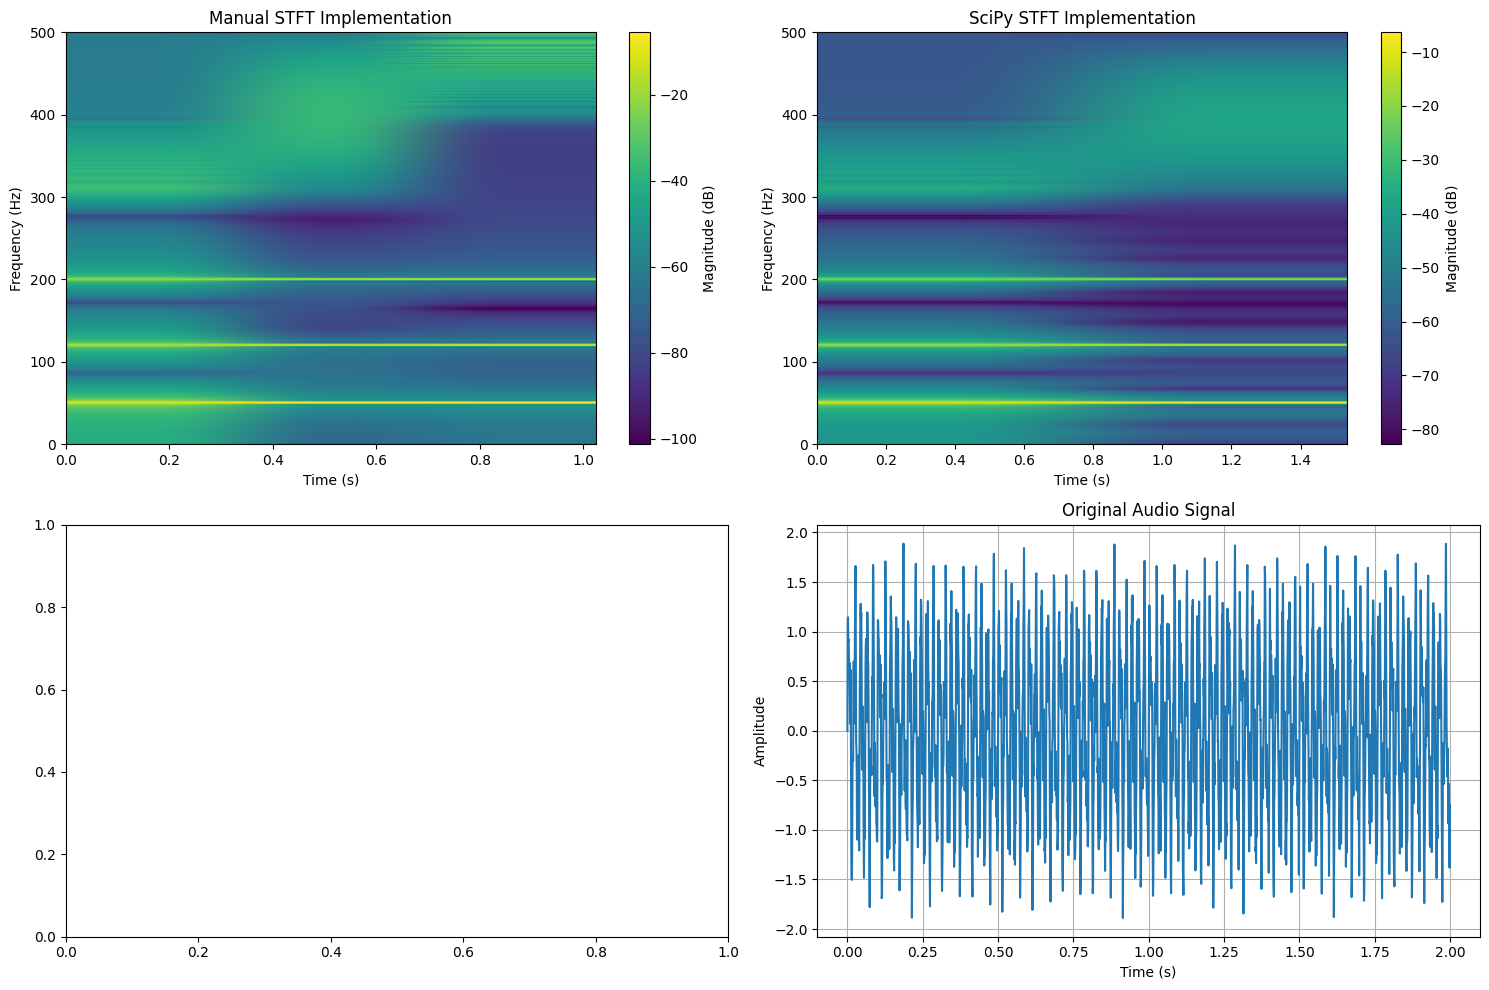

In [114]:
# test signal
# Create test signal
sr = 1000  # Sample rate
duration = 2
t = np.linspace(0, duration, int(sr * duration), endpoint=False)

# Multi-frequency signal
signal_test = (np.sin(2 * np.pi * 50 * t) +        # 50 Hz
                0.5 * np.sin(2 * np.pi * 120 * t) +  # 120 Hz
                0.3 * np.sin(2 * np.pi * 200 * t))   # 200 Hz

# Add some time-varying component
signal_test += 0.2 * np.sin(2 * np.pi * (300 + 100 * t) * t)  # Frequency sweep

plot_stft_comparison(signal_test, sr)

# Takeaways

Cogratulations you now know how to create a spectrogram by implementing the fourier transform formula! Hopefully this gave some intuition on how the fourier transform works and why it has properties that are valuable for audio identification.

While we will be using scipy's sftf function going forward, we are able to interpret what the 3 outputs of the functions are. The first is an array of frequency bins, the second is an array of time stamps, and the third is a 2d matrix where the first dimension is the frequency, the second dimension is the timestamp, and each value is the magnitude of that frequency.